# YouTube trending videos

In [12]:
import numpy as np
from numpy import nan
nan
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

from helpers.files import load_csv

numeric_attrs = [
    "views", "likes", "dislikes", "comment_count", "description_len", "title_len", "channel_title_len",
    "publish_time_day_of_week", "publish_time_hour_of_day"
]


## Etap 5 - Zbieranie danych nie-trending

### Skrypt do zbierania danych trending

Pierwszym krokiem, który został wykonany w ramach tego etapu było
zapoznanie się z oryginalnym skryptem do pobierania danych „trending".
Skrypt jest dostępny w repozytorium [Trending-Youtube-Scraper](https://github.com/mitchelljy/Trending-YouTube-Scraper).

Oryginalny skrypt do pobierania danych -> w jego
kontekscie można opisać dlaczego tak pobieramy

### Pomysł na pobranie danych nie trending

- Podział okresu 11.2017-07.2018 na 4 podokresy
- Zbieranie danych „proporcjami” wystąpień kategorii podobnymi do oryginalnych
- Filtrowanie filmów trending
- Filtrowanie ewentualnych powtórzeń
- Uzupełnianie statystyk

Testowe dane

### Wczytanie danych trending

In [13]:
gb_videos, us_videos = load_csv("ped3_data")
trending_videos = pd.concat([gb_videos, us_videos])

for name in numeric_attrs:
    trending_videos[name] = trending_videos[name].apply(lambda x: eval(x)[0] if eval(x) else np.nan)



### Wczytanie danych nie trending

In [36]:
gb_non_videos, us_non_videos = load_csv("ped5_full_data")
non_trending_videos = pd.concat([gb_non_videos, us_non_videos])
non_trending_videos.rename(columns={"category_id": "new_category_id"}, inplace=True)

['-0CMnp02rNY', '-0NYY8cqdiQ', '-1Hm41N0dUs', '-1yT-K3c6YI', '-2RVw2_QyxQ', '-2aVkGcI7ZA', '-2b4qSoMnKE', '-2wRFv-mScQ', '-35jibKqbEo', '-37nIo_tLnk', '-39ysKKpE7I', '-3h4Xt9No9o', '-3nEHRN6IPg', '-4s2MeUgduo', '-5aaJJQFvOg', '-66xHRJSPxs', '-7AZX5Xtiks', '-7UzyXO-mzk', '-7_ATlZ-zMc', '-8ZHXaGILlc', '-9OfAHgdV8Y', '-9rdDeWzvsU', '-AY-HC4sUGU', '-BDImdAfodA', '-BQJo3vK8O8', '-C5q3oir8gA', '-CS84oCtjvc', '-C_rvt0SwLE', '-EL8TuMsb-k', '-El8z4uy5Ac', '-HoAafTYR9w', '-HrakxB4Klo', '-IqpbDJFbZA', '-JVITToppE0', '-KB5QbOS4s4', '-L4RYm9Tq7I', '-NEhvlJA5q8', '-NIP2zgVsRY', '-NcG4L0pwvE', '-OK9i1_YYYc', '-Q5pHm2Cfq4', '-QPdRfqTnt4', '-QR-TB_k20M', '-Qv6p6pTz5I', '-QxZv_wJ1aA', '-R9F2_D76TE', '-RUbNqpwOt8', '-RmUADCWI4A', '-SIp6xSP7ds', '-SJywvgaJEI', '-TQpVg4vcrk', '-V1Oo7srGf0', '-VgOGzBcMIg', '-W6v2_0evUU', '-WRcZ9xHMuE', '-WedqN1iYbM', '-YRlVB6Qgug', '-_jlqATo9eo', '-a12nTEcoqE', '-cQoGwpDBPs', '-e-xXN-tcFU', '-gfGtIHfU7A', '-hI5Ds3IgVM', '-hg9t3PdhFE', '-hg_VRwS5RI', '-kETYvHON_I', '-kTWIm7m

### Atrybuty liczbowe

**Funkcja do rysowania wykresów**

In [15]:
def plot_numeric_attr(attr_name: str, trending: pd.DataFrame, non_trending: pd.DataFrame) -> None:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
    gs = GridSpec(2, 4)
    gs.update(wspace=0.5)
    axes[0, 0].hist(trending[attr_name])
    axes[0, 0].title.set_text(f"Trending: {attr_name}")
    axes[0, 1].hist(non_trending[attr_name])
    axes[0, 1].title.set_text(f"Non Trending: {attr_name}")
    axes[1, 0].boxplot(
        [trending[trending[attr_name].notna()][attr_name], non_trending[attr_name]],
        labels=["Trending", "Non Trending"]
    )
    axes[1, 1].boxplot(
        [trending[trending[attr_name].notna()][attr_name], non_trending[attr_name]],
        labels=["Trending", "Non Trending"],
        showfliers=False
    )

**Views**

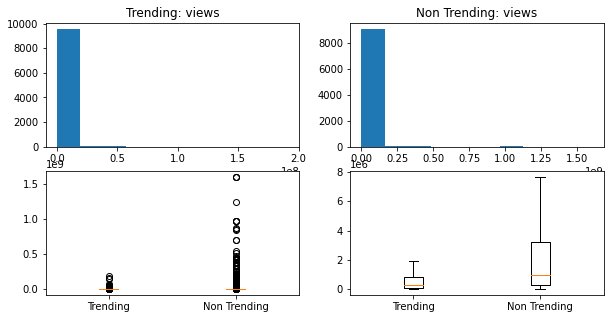

In [16]:
plot_numeric_attr("views", trending_videos, non_trending_videos)

**Likes**

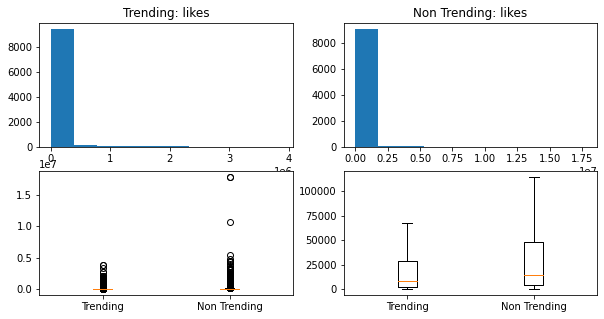

In [17]:
plot_numeric_attr("likes", trending_videos, non_trending_videos)

**Dislikes**

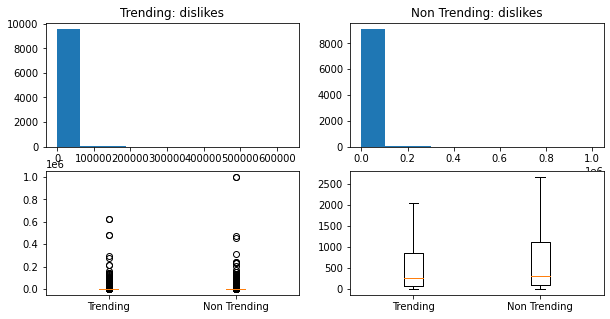

In [18]:
plot_numeric_attr("dislikes", trending_videos, non_trending_videos)

**Comment Count**

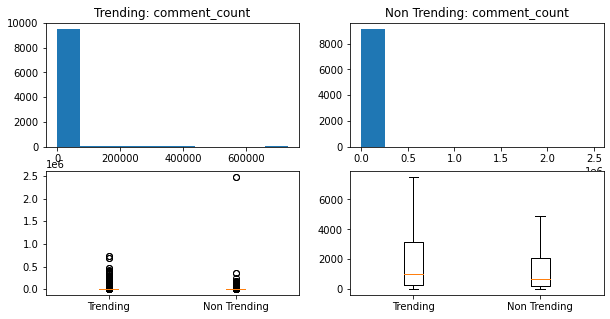

In [19]:
plot_numeric_attr("comment_count", trending_videos, non_trending_videos)

**Description length**

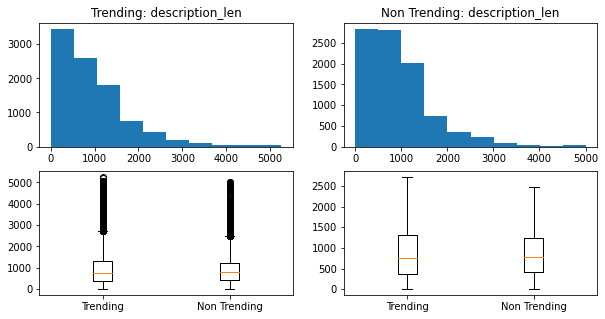

In [20]:
plot_numeric_attr("description_len", trending_videos, non_trending_videos)

**Title length**

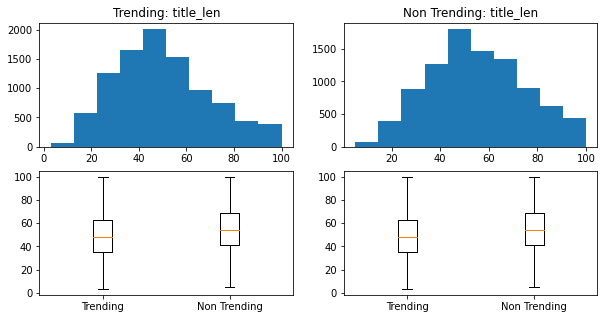

In [21]:
plot_numeric_attr("title_len", trending_videos, non_trending_videos)

**Channel title length**

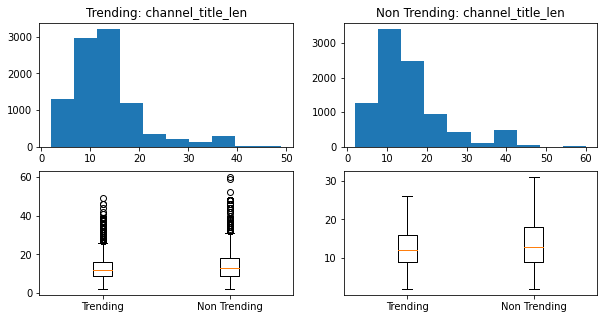

In [22]:
plot_numeric_attr("channel_title_len", trending_videos, non_trending_videos)


### Atrybuty czasowe

**Dzień opublikowania filmu**

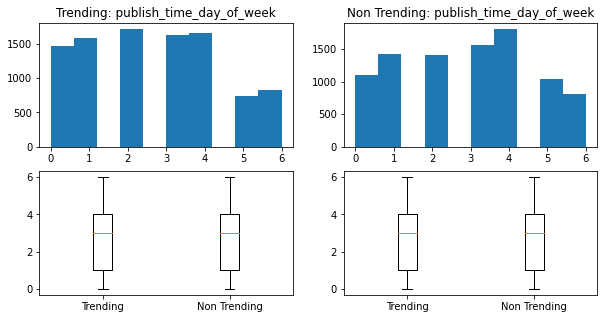

In [23]:
plot_numeric_attr("publish_time_day_of_week", trending_videos, non_trending_videos)

**Godzina opublikowania filmu**

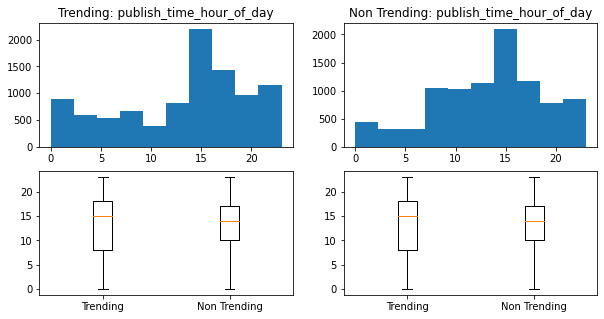

In [24]:
plot_numeric_attr("publish_time_hour_of_day", trending_videos, non_trending_videos)


